## AABC cumulative recruitment stats and visuals


In [1]:
# run all and then, from the command line:
#jupyter nbconvert --to html --no-input AABC_HCA_recruitmentstats.ipynb


In [2]:
#load some libraries
import pandas as pd
import seaborn as sns
from ccf.box import LifespanBox
import yaml
from functions import *
from config import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

In [3]:
print(date.today().strftime("%m/%d/%Y"))

04/25/2023


In [4]:
#load HCA inventory 
config = LoadSettings()
secret=pd.read_csv(config['config_files']['secrets'])
box = LifespanBox(cache="./tmp")
pathp=box.downloadFile(config['hcainventory'])
ids=pd.read_csv(pathp)

In [5]:
#load AABC report
aabcarms = redjson(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0])
hcpa = redjson(tok=secret.loc[secret.source=='hcpa','api_key'].reset_index().drop(columns='index').api_key[0])
#just a report
aabcreport = redreport(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0],reportid='51031')

#download the inventory report from AABC for comparison
aabcinvent=getframe(struct=aabcreport,api_url=config['Redcap']['api_url10'])


HTTP Status: 200


In [6]:
aabcinvent['todaydate']=date.today()
aabcinvent['dayspassed']=(pd.to_datetime(aabcinvent.todaydate) - pd.to_datetime(aabcinvent.v0_date)).dt.days


#get list of subjects who passed recruitment and registered for a visit
#for i in list(aabcinvent.columns):
#    print(i)
    
subjects=aabcinvent[['study_id','subject_id','redcap_event_name','passedscreen','register_subject_complete','register_visit_complete']]
#print(subjects.shape)
subjects=subjects.loc[subjects.register_visit_complete =='2'][['study_id']]
subs=list(subjects.study_id)


In [7]:

forplot=aabcinvent.loc[(aabcinvent.study_id.isin(subs)) & (aabcinvent.redcap_event_name.str.contains('register'))][['v0_date','dayspassed','age','sex','racial','ethnic','site','counterbalance_1st']]
forplot=forplot.sort_values('dayspassed')

#forplot.head()

In [8]:
#PREPARE DATA FOR PLOTS
#forplot['sexsum']=
S=pd.get_dummies(forplot.sex, prefix='sex')

#forplot['sexsum']=pd.to_numeric(forplot.sex, errors='coerce').cumsum()
forplot['malesum']=pd.to_numeric(S.sex_1, errors='coerce').cumsum()
forplot['femalesum']=pd.to_numeric(S.sex_2, errors='coerce').cumsum()
forplot['Sex']=forplot.sex.replace({'1':'Male','2':'Female'})

S0=pd.get_dummies(forplot.counterbalance_1st, prefix='CB')
forplot['CB3sum']=pd.to_numeric(S0.CB_3, errors='coerce').cumsum()
forplot['CB4sum']=pd.to_numeric(S0.CB_4, errors='coerce').cumsum()
forplot['Counterbalance']=forplot.counterbalance_1st.replace({'3':'CB3','4':'CB4'})

#forplot.head()

In [9]:
#1, Native American/Alaskan Native | 2, Asian | 3, Black or African American | 4, Native Hawaiian or Other Pacific Is | 5, White | 6, More than one race | 99, Unknown or Not reported
S2=pd.get_dummies(forplot.racial, prefix='race')
#print(S2.head())
forplot['whitesum']=pd.to_numeric(S2.race_5, errors='coerce').cumsum()
#forplot['natpacsum']=pd.to_numeric(S2.race_4, errors='coerce').cumsum()
forplot['blacksum']=pd.to_numeric(S2.race_3, errors='coerce').cumsum()
forplot['asiansum']=pd.to_numeric(S2.race_2, errors='coerce').cumsum()
forplot['natamersum']=pd.to_numeric(S2.race_1, errors='coerce').cumsum()
forplot['moret1sum']=pd.to_numeric(S2.race_6, errors='coerce').cumsum()
forplot['nasum']=pd.to_numeric(S2.race_99, errors='coerce').cumsum()
forplot['Race']=forplot.racial.replace({'1':'Nat Amer/Alaskan','2':'Asian','3':'Black','4':'Nat Hawaiian/PI','5':'White','6':'More than one','99':'Unknown'})

#thnicity
S3=pd.get_dummies(forplot.ethnic, prefix='ethnicity')
forplot['hispanicsum']=pd.to_numeric(S3.ethnicity_1, errors='coerce').cumsum()
forplot['nonhispanicsum']=pd.to_numeric(S3.ethnicity_2, errors='coerce').cumsum()
forplot['unkhispsum']=pd.to_numeric(S3.ethnicity_3, errors='coerce').cumsum()
forplot['Ethnicity']=forplot.ethnic.replace({'1':'Hispanic','2':'Non-Hispanic','3':'Unknown'})

#sites
S4=pd.get_dummies(forplot.site, prefix='site')
forplot['wusum']=pd.to_numeric(S4.site_4, errors='coerce').cumsum()
forplot['umnsum']=pd.to_numeric(S4.site_3, errors='coerce').cumsum()
forplot['mghsum']=pd.to_numeric(S4.site_1, errors='coerce').cumsum()
forplot['uclasum']=pd.to_numeric(S4.site_2, errors='coerce').cumsum()
forplot['Site']=forplot.site.replace({'1':'MGH','2':'UCLA','3':'UMN','4':'WashU'})

In [10]:
                                       
##ages
bins= [30,40,50,60,70,80,90,120]
forplot['ages']=pd.to_numeric(forplot.age)
forplot['AgeGroup'] = pd.cut(forplot['ages'], bins=bins,right=False)# labels=labels,
S5=pd.get_dummies(forplot.AgeGroup, prefix='age')
forplot['age30sum']=pd.to_numeric(S5['age_[30, 40)'], errors='coerce').cumsum()
forplot['age40sum']=pd.to_numeric(S5['age_[40, 50)'], errors='coerce').cumsum()
forplot['age50sum']=pd.to_numeric(S5['age_[50, 60)'], errors='coerce').cumsum()
forplot['age60sum']=pd.to_numeric(S5['age_[60, 70)'], errors='coerce').cumsum()
forplot['age70sum']=pd.to_numeric(S5['age_[70, 80)'], errors='coerce').cumsum()
forplot['age80sum']=pd.to_numeric(S5['age_[80, 90)'], errors='coerce').cumsum()
forplot['age90sum']=pd.to_numeric(S5['age_[90, 120)'],errors='coerce').cumsum()
#forplot.columns

## AABC Univariate Counts

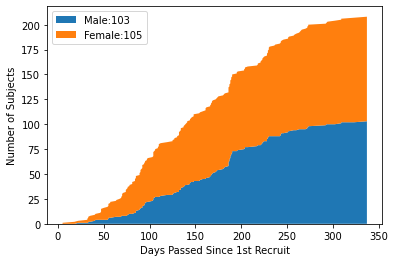

In [11]:
### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.malesum) #[1,4,6,8,9]
y2=list(forplot.femalesum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['Male:'+str(max(y1)),'Female:'+str(max(y2))])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');



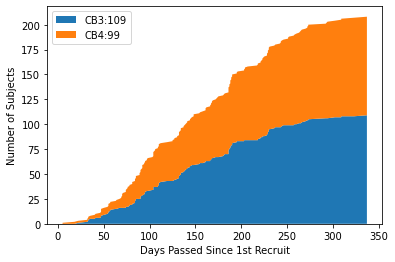

In [12]:
### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.CB3sum) #[1,4,6,8,9]
y2=list(forplot.CB4sum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['CB3:'+str(max(y1)),'CB4:'+str(max(y2))])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

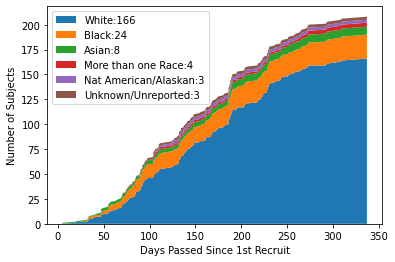

In [13]:
#BY RACE
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.whitesum) #[1,4,6,8,9]
y2=list(forplot.blacksum)#[2,2,7,10,12]
y3=list(forplot.asiansum)
y4=list(forplot.moret1sum)
#y5=list(forplot.natpacsum)
y6=list(forplot['natamersum'])
y7=list(forplot['nasum'])



# Basic stacked area chart.
plt.stackplot(x,y1,y2,y3,y4,y6,y7,labels=['White:'+str(max(y1)),'Black:'+str(max(y2)),'Asian:'+str(max(y3)),'More than one Race:'+str(max(y4)),'Nat American/Alaskan:'+str(max(y6)),'Unknown/Unreported:'+str(max(y7))])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

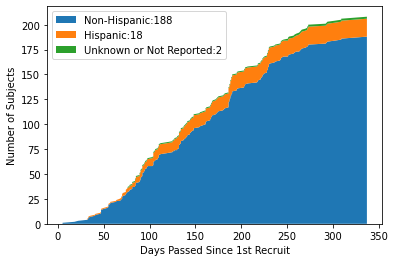

In [14]:
#BY ETHNICITY
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.nonhispanicsum) #[1,4,6,8,9]
y2=list(forplot.hispanicsum)#[2,2,7,10,12]
y3=list(forplot.unkhispsum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, labels=['Non-Hispanic:'+str(max(y1)),'Hispanic:'+str(max(y2)),'Unknown or Not Reported:'+str(max(y3))])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

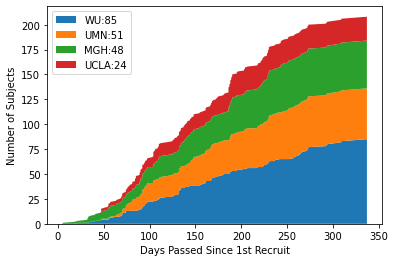

In [15]:
#By Site
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.wusum) #[1,4,6,8,9]
y2=list(forplot.umnsum)#[2,2,7,10,12]
y3=list(forplot.mghsum)
y4=list(forplot.uclasum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, y4,labels=['WU:'+str(max(y1)),'UMN:'+str(max(y2)),'MGH:'+str(max(y3)),'UCLA:'+str(max(y4))])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');


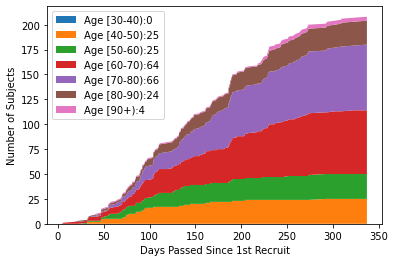

In [16]:
#By Age Bin
x=list(forplot.dayspassed) #range(1,6)
y2=list(forplot.age30sum)#[2,2,7,10,12]
y3=list(forplot.age40sum)
y4=list(forplot.age50sum)
y5=list(forplot.age60sum)
y6=list(forplot.age70sum)
y7=list(forplot.age80sum)
y8=list(forplot.age90sum)

# Basic stacked area chart.
plt.stackplot(x,y2,y3,y4,y5,y6,y7,y8, labels=['Age [30-40):'+str(max(y2)),'Age [40-50):'+str(max(y3)),'Age [50-60):'+str(max(y4)),'Age [60-70):'+str(max(y5)),'Age [70-80):'+str(max(y6)),'Age [80-90):'+str(max(y7)),'Age [90+):'+str(max(y8))])
plt.legend(loc='upper left')

plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

## AABC Crosstabulations


Site,MGH,UCLA,UMN,WashU
Race,,,,
Asian,3,1,4,0
Black,7,3,6,8
More than one,0,2,0,2
Nat Amer/Alaskan,0,1,1,1
Unknown,1,1,1,0
White,37,16,39,74


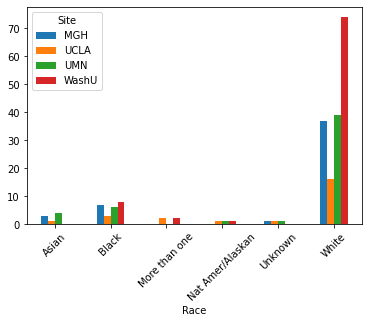

In [17]:
#Crosstabs x Site

pd.crosstab(forplot.Race,forplot.Site).plot.bar(rot=45)
#pd.crosstab(forplot.Race,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Site)

Site,MGH,UCLA,UMN,WashU
Ethnicity,,,,
Hispanic,3,9,4,2
Non-Hispanic,45,14,46,83
Unknown,0,1,1,0


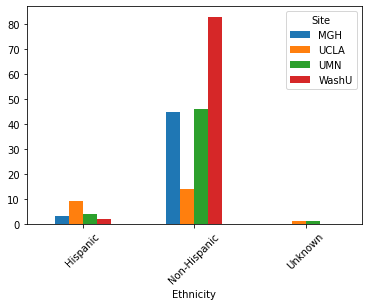

In [18]:
pd.crosstab(forplot.Ethnicity,forplot.Site).plot.bar(rot=45)
#pd.crosstab(forplot.Ethnicity,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Ethnicity,forplot.Site)

Site,MGH,UCLA,UMN,WashU
AgeGroup,,,,
"[40, 50)",6,3,8,8
"[50, 60)",6,7,3,9
"[60, 70)",17,6,16,25
"[70, 80)",13,6,16,31
"[80, 90)",5,2,6,11
"[90, 120)",1,0,2,1


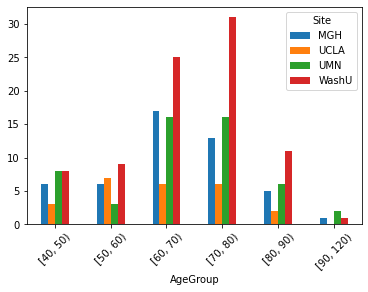

In [19]:
pd.crosstab(forplot.AgeGroup,forplot.Site).plot.bar(rot=45)
#pd.crosstab(forplot.AgeGroup,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Site)

Site,MGH,UCLA,UMN,WashU
Sex,,,,
Female,22,8,30,45
Male,26,16,21,40


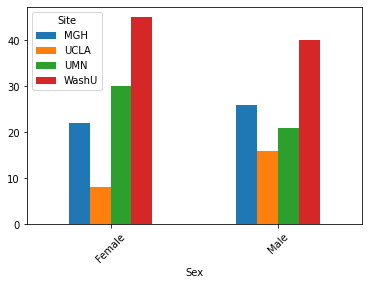

In [20]:
pd.crosstab(forplot.Sex,forplot.Site).plot.bar(rot=45)
#pd.crosstab(forplot.Sex,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Sex,forplot.Site)

Race,Asian,Black,More than one,Nat Amer/Alaskan,Unknown,White
AgeGroup,,,,,,
"[40, 50)",2,6,1,0,0,16
"[50, 60)",1,8,1,2,2,11
"[60, 70)",4,6,1,1,1,51
"[70, 80)",0,4,1,0,0,61
"[80, 90)",1,0,0,0,0,23
"[90, 120)",0,0,0,0,0,4


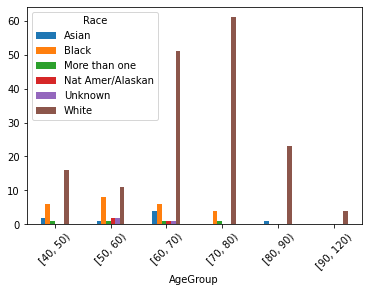

In [21]:
pd.crosstab(forplot.AgeGroup,forplot.Race).plot.bar(rot=45)
#pd.crosstab(forplot.AgeGroup,forplot.Race).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Race)

Ethnicity,Hispanic,Non-Hispanic,Unknown
AgeGroup,,,
"[40, 50)",4,21,0
"[50, 60)",6,18,1
"[60, 70)",4,59,1
"[70, 80)",4,62,0
"[80, 90)",0,24,0
"[90, 120)",0,4,0


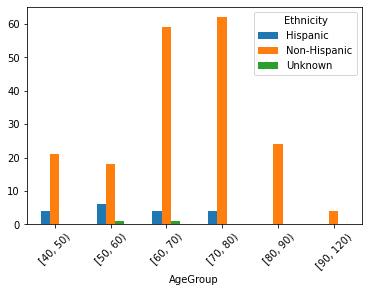

In [22]:
pd.crosstab(forplot.AgeGroup,forplot.Ethnicity).plot.bar(rot=45)
#pd.crosstab(forplot.AgeGroup,forplot.Ethnicity).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Ethnicity)


Sex,Female,Male
AgeGroup,,
"[40, 50)",11,14
"[50, 60)",12,13
"[60, 70)",38,26
"[70, 80)",26,40
"[80, 90)",16,8
"[90, 120)",2,2


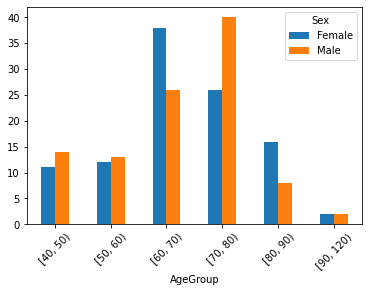

In [23]:
pd.crosstab(forplot.AgeGroup,forplot.Sex).plot.bar(rot=45)
#pd.crosstab(forplot.AgeGroup,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Sex)

Sex,Female,Male
Race,,
Asian,4,4
Black,14,10
More than one,0,4
Nat Amer/Alaskan,2,1
Unknown,2,1
White,83,83


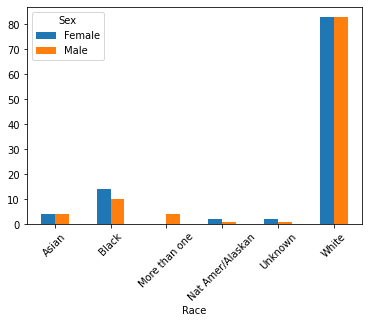

In [24]:
#Crosstabs
pd.crosstab(forplot.Race,forplot.Sex).plot.bar(rot=45)
#pd.crosstab(forplot.Race,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Sex)

Sex,Female,Male
Ethnicity,,
Hispanic,6,12
Non-Hispanic,98,90
Unknown,1,1


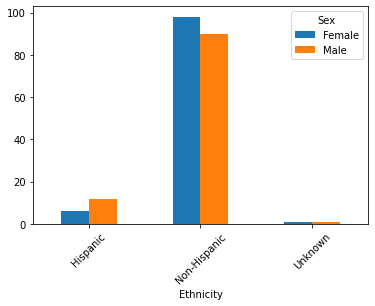

In [25]:
#Crosstabs
pd.crosstab(forplot.Ethnicity,forplot.Sex).plot.bar(rot=45)
#pd.crosstab(forplot.Ethnicity,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Ethnicity,forplot.Sex)

Sex,Female,Male
Counterbalance,,
CB3,54,55
CB4,51,48


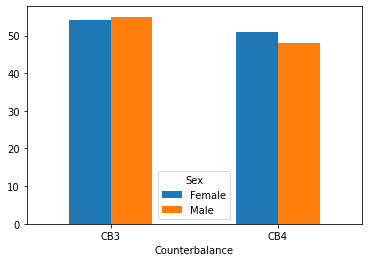

In [26]:
#Crosstabs
pd.crosstab(forplot.Counterbalance,forplot.Sex).plot.bar(rot=0)
#pd.crosstab(forplot.Counterbalance,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Counterbalance,forplot.Sex)

Counterbalance,CB3,CB4
Race,,
Asian,2,6
Black,12,12
More than one,3,1
Nat Amer/Alaskan,2,1
Unknown,1,2
White,89,77


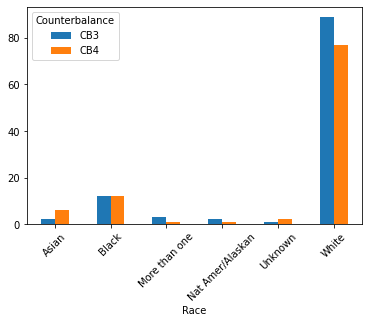

In [27]:
#Crosstabs
pd.crosstab(forplot.Race,forplot.Counterbalance).plot.bar(rot=45)
#pd.crosstab(forplot.Race,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Counterbalance)

Counterbalance,CB3,CB4
AgeGroup,,
"[40, 50)",16,9
"[50, 60)",15,10
"[60, 70)",29,35
"[70, 80)",32,34
"[80, 90)",14,10
"[90, 120)",3,1


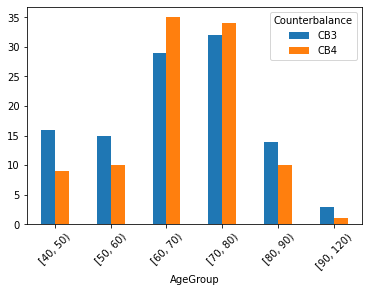

In [28]:
#Crosstabs
pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).plot.bar(rot=45)
#pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Counterbalance)

In [29]:
## UNIVARIATE HCA demographic stats

In [30]:
#request or load REDCAP API Key

In [31]:
##subset to v1 for recruitment stats
#forstats=ids[['subject','redcap_event','event_age','site','M/F','race','ethnic_group','pedid']].loc[ids.redcap_event.isin(['V1','V2'])].sort_values('redcap_event').drop_duplicates(subset='subject',keep='first')


In [32]:
#bin ages
#bins= [20,30,40,50,60,70,80,90,100,110]
#forstats['AgeGroup'] = pd.cut(forstats['event_age'], bins=bins,right=False)# labels=labels,

In [33]:
#a=pd.DataFrame(forstats.groupby(['site']).count().pedid).rename(columns={'pedid':'count'})
#a.to_csv('HCA_Site.csv')
#b=pd.DataFrame(forstats.groupby(['AgeGroup']).count().pedid).rename(columns={'pedid':'count'})
#b.to_csv('HCA_Age.csv')
#c=pd.DataFrame(forstats.groupby(['M/F']).count().pedid).rename(columns={'pedid':'count'})
#c.to_csv('HCA_Sex.csv')
#d=pd.DataFrame(forstats.groupby(['race']).count().pedid).rename(columns={'pedid':'count'})
#d.to_csv('HCA_Race.csv')
#e=pd.DataFrame(forstats.groupby(['ethnic_group']).count().pedid).rename(columns={'pedid':'count'})
#e.to_csv('HCA_Ethnicity.csv')


In [34]:
## HCA demographics by Age

In [35]:
#print('************  BY AGE  ********************')
#print(forstats.groupby(['AgeGroup','site']).count().pedid)
#pd.DataFrame(pd.crosstab(forstats['AgeGroup'], [forstats.site])).to_csv('HCA_Age_x_Site.csv',index=True)
#print('*******************************************************')
#print(forstats.groupby(['AgeGroup','M/F']).count().pedid)
#pd.DataFrame(pd.crosstab(forstats['AgeGroup'], forstats['M/F'])).to_csv('HCA_Age_x_Sex.csv',index=True)
#print('*******************************************************')
#print(forstats.groupby(['AgeGroup','race']).count().pedid)
#pd.DataFrame(pd.crosstab(forstats['AgeGroup'], [forstats.race])).to_csv('HCA_Age_x_Race.csv',index=True)
#print('*******************************************************')
#print(forstats.groupby(['AgeGroup','ethnic_group']).count().pedid)
#pd.DataFrame(pd.crosstab(forstats['AgeGroup'], [forstats.ethnic_group])).to_csv('HCA_Age_x_Ethnicity.csv',index=True)
#print('*******************************************************')

In [36]:
# # HCA demographics by Site

In [37]:
#print('************* BY SITE *********************')
#print(forstats.groupby(['site','M/F']).count().pedid)
#pd.DataFrame(pd.crosstab(forstats['site'], [forstats['M/F']])).to_csv('HCA_Site_x_Sex.csv',index=True)
#print('*******************************************************')
#print(forstats.groupby(['site','race']).count().pedid)
#pd.DataFrame(pd.crosstab(forstats['site'], [forstats.race])).to_csv('HCA_Site_x_Race.csv',index=True)
#print('*******************************************************')
#print(forstats.groupby(['site','ethnic_group']).count().pedid)
#pd.DataFrame(pd.crosstab(forstats['site'], [forstats.ethnic_group])).to_csv('HCA_Site_x_Ethnicity.csv',index=True)
#print('*******************************************************')
#
#print('************ BY SEX **********************')
#pd.DataFrame(pd.crosstab(forstats['M/F'], [forstats['race']])).to_csv('HCA_Sex_x_Race.csv',index=True)
#print('*******************************************************')
#pd.DataFrame(pd.crosstab(forstats['M/F'], [forstats['ethnic_group']])).to_csv('HCA_Sex_x_Ethnicity.csv',index=True)
#print('*******************************************************')

#print('************ BY RACE **********************')
#pd.DataFrame(pd.crosstab(forstats['race'], [forstats['ethnic_group']])).to_csv('HCA_Race_x_Ethnicity.csv',index=True)
#print('*******************************************************')